In [1]:
import sys;

# setup path to location of gmlsnets_pytorch (if not install system-wide)
path_gmlsnets_pytorch = '../../';
sys.path.append(path_gmlsnets_pytorch);
import torch;
import torch.nn as nn;
import torch.optim as optim
from torch.autograd import Variable
import numpy as np;
import matplotlib.pyplot as plt;
import math
import os
# setup gmlsnets package
import gmlsnets_pytorch as gmlsnets;
import gmlsnets_pytorch.nn;
import gmlsnets_pytorch.vis;
import gmlsnets_pytorch.dataset;

# dereference a few common items
MapToPoly_Function = gmlsnets.nn.MapToPoly_Function;
get_num_polys = MapToPoly_Function.get_num_polys;
weight_one_minus_r = MapToPoly_Function.weight_one_minus_r;
eval_poly = MapToPoly_Function.eval_poly;

print("Packages:");
print("torch.__version__ = " + str(torch.__version__));
print("numpy.__version__ = " + str(np.__version__));
print("gmlsnets.__version__ = " + str(gmlsnets.__version__));

Packages:
torch.__version__ = 1.5.0
numpy.__version__ = 1.21.5
gmlsnets.__version__ = 1.0.0


In [2]:
# Setup the parameters
batch_size = int(1e1);
flag_extend_periodic = False; # periodic boundaries
flag_dataset = 'diffOp2';
run_name = '%s_Test1'%flag_dataset;
base_dir = './output/regression_diff_op_2d/%s'%run_name;
flag_save_figs = True;
fig_base_dir = '%s/fig'%base_dir;
flag_print_model = False;
 

if not os.path.exists(base_dir):
  os.makedirs(base_dir);

if not os.path.exists(fig_base_dir):
  os.makedirs(fig_base_dir);

# Configure devices
if torch.cuda.is_available():  
  num_gpus = torch.cuda.device_count();
  print("num_gpus = " + str(num_gpus));
  if num_gpus >= 4:
    device = torch.device('cuda:3');
  else:
    device = torch.device('cuda:0');
else: 
  device = torch.device('cpu');
print("device = " + str(device));

device = cpu


In [3]:
Nx = 61;Ny = 61; 
nx = Nx; ny = Ny;

NNx = 3*Nx; NNy = 3*Ny; # simple periodic by tiling for now
aspect_ratio = NNx/float(NNy);
xx = np.linspace(-1.5,aspect_ratio*1.5,Nx); xx = xx.astype(float);
yy = np.linspace(-1.5,1.5,Ny); yy = yy.astype(float);
h = 3/(Nx-1)

aa = np.meshgrid(xx,yy);
np_xj = np.array([aa[0].flatten(), aa[1].flatten()]).T;

aa = np.meshgrid(xx,yy);
np_xi = np.array([aa[0].flatten(), aa[1].flatten()]).T;

# make torch tensors
xj = torch.from_numpy(np_xj).float().to(device); # convert to torch tensors
xj.requires_grad = True;

xi = torch.from_numpy(np_xi).float().to(device); # convert to torch tensors
xi.requires_grad = True;



In [4]:
if flag_dataset == 'diffOp2':
  
  flag_verbose = 1;
  #op_type = r'\Delta{u}';op_type = r'\Delta{u}*\Delta{u}';
  #op_type = r'u\Delta{u}';op_type = r'\grad{u}';op_type = r'u\grad{u}';
  #op_type = r'\grad{u}\cdot\grad{u}';
  op_type = r'u\Delta{u}';
    
  num_dim = 2;
  num_training_samples = int(5e3);
  nchannels_u = 1;  
  Nc = nchannels_u;

  #alpha1 = 0.05;
  alpha1 = 0.3;
  scale_factor = 1e2;
  train_dataset = gmlsnets.dataset.diffOp2(op_type=op_type,op_params=None,
                                           gen_mode='exp1',gen_params={'alpha1':alpha1},
                                           num_samples=num_training_samples,
                                           nchannels=nchannels_u,nx=nx,ny=ny,
                                           noise_factor=0,scale_factor=scale_factor,
                                           flag_verbose=flag_verbose);
  
  train_dataset = train_dataset.to(device);
  if flag_verbose > 0:
    print("done.");

  num_test_samples = int(1e3);
  scale_factor = 1e2;
  test_dataset = gmlsnets.dataset.diffOp2(op_type=op_type,op_params=None,
                                          gen_mode='exp1',gen_params={'alpha1':alpha1},
                                          num_samples=num_test_samples,
                                          nchannels=nchannels_u,nx=nx,ny=ny,
                                          noise_factor=0,scale_factor=scale_factor,
                                          flag_verbose=flag_verbose);
  test_dataset = test_dataset.to(device);

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False);

# Cound number of output channels in f, determines if scalar or vector valued data
nchannels_f = train_dataset.samples_Y.shape[1];



Generating the data samples which can take some time.
num_samples = 5000
done.
Generating the data samples which can take some time.
num_samples = 1000


In [5]:
flag_run_cell = True;
if flag_run_cell:
    # Show subset of the data 
    img_arr = [];
    label_str_arr = [];

    numImages = len(train_dataset);
    #II = np.random.permutation(numImages); # compute random collection of indices @optimize
    II = np.arange(numImages);

    if flag_dataset == '' or 0 == 0:          
      img_arr = [];
      channelI = 0; # for vector-valued fields, choose component.
      for I in np.arange(0,min(num_training_samples,4)):        
        img_arr.append(train_dataset[II[I],channelI,:][0].cpu());
 #     gmlsnets.vis.plot_image_array(img_arr,title=r'$u^{[i]}$ Samples',figSize=(6,6),title_yp=0.95);
    
      sample_img = img_arr[0]
    
      if flag_save_figs:
        fig_name = 'samples_u';
        gmlsnets.vis.save_fig('%s/%s'%(fig_base_dir,fig_name),'',flag_verbose=True,dpi_set=200,flag_pdf=True);
        

saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u.pdf
saveFilename = ./output/regression_diff_op_2d/diffOp2_Test1/fig/samples_u.png


<Figure size 432x288 with 0 Axes>

In [6]:
# Define a heat map plot
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='jet')
    plt.colorbar()
    plt.axis("off")
    plt.savefig('heatmap1.png', dpi=120)
    plt.show()
    plt.draw()

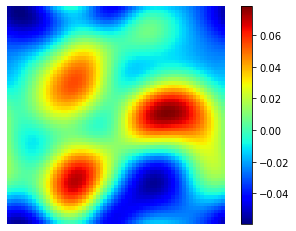

<Figure size 432x288 with 0 Axes>

In [8]:
N_u = 50

u_np = np.zeros((N_u,Nx,Ny))
u_np[:,:,:] = train_dataset[0:N_u,0,:,:][0]
heatmap2d(u_np[0,:,:])



58


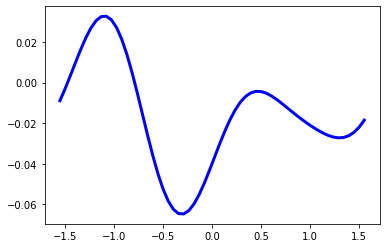

In [9]:
# Discretize a domain
C = 1.5
h = 2*C/(Nx-4)
x = np.arange(-C, C+h, h)
x_2 = np.arange(-C-h, C+2*h, h)
N = len(x)
print(N)
N_2 = len(x_2)

# Number of functions for our data
M = 30

z_tensor = torch.zeros(M,1,1,N)
discretization = torch.zeros(M,1,1,N)
z_deriv_tensor = torch.zeros(M,1,1,N)
z_deriv_tensor_2 = torch.zeros(M,1,1,N+1)

# Generate data
for i in range(0,M):
    a = np.random.uniform(-1,1,1)
    b = np.random.uniform(-1,1,1)
    c = np.random.uniform(-1,1,1)
    z_2 = u_np[i,0,0:(N+2)]
    z = z_2[1:N+1]
    
    z_tensor[i,0,0,:] = torch.tensor(z)
    z_tensor = z_tensor.float()
    discretization[i,0,0,:] = torch.tensor(x)
    
    k = 0
    for j in range(0,N+1):
        z_deriv_tensor_2[i,0,0,k] = (z_2[j+1] - z_2[j])/h
        k = k+1
    z_deriv_tensor[i,0,0,:] = z_deriv_tensor_2[i,0,0,0:(N)]
    
    
# Reshape tensor
discretization_reshape = torch.reshape(discretization, (-1,))

# Initialize tensors for input data

z_NN_input_branch_0 = z_tensor.repeat(1,N,1,1)
z_NN_input_branch_np = z_NN_input_branch_0.detach().numpy().squeeze()
z_NN_input_branch_np = np.reshape(z_NN_input_branch_np, (N*M,N))


z_NN_input_branch = torch.tensor(z_NN_input_branch_np)
z_NN_input_trunk = discretization_reshape.repeat(1,1,1,1)
z_NN_input_trunk = torch.reshape(z_NN_input_trunk, (N*M,1))
z_NN_target = torch.reshape(z_deriv_tensor, (N*M,1))

#print(z_NN_target)
#print(z_NN_input_trunk)
#print(z_NN_target)

plt.savefig("1DFunction.png")
#plt.plot(x,z_deriv_tensor[M-1].squeeze().detach().numpy(), color="blue", linewidth=3)
plt.savefig("1DFunction.png")
plt.plot(x_2[0:N+2],z_2, color='blue', linewidth=3)
plt.savefig("1DFunction.png")

In [10]:
# Create neural networks for Unstacked DeepONet

class Unstacked_Branch(nn.Module):
    def __init__(self):
        super(Unstacked_Branch, self).__init__()
        self.layer1 = nn.Linear(N, 200, bias=True)
        self.layer2 = nn.Linear(200, 200, bias=True)
        self.layer3 = nn.Linear(200, 10, bias=True)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        out = self.activation(out)
        out = self.layer3(out)
        return out
    
    
class Trunk(nn.Module):
    def __init__(self):
        super(Trunk, self).__init__()
        self.layer1 = nn.Linear(1, 200, bias=True)
        self.layer2 = nn.Linear(200,200, bias=True)
        self.layer3 = nn.Linear(200,10, bias=True)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        out = self.activation(out)
        out = self.layer3(out)
        return out
    



Unstacked_Branch = Unstacked_Branch()
Trunk = Trunk()
print(Unstacked_Branch)
print(Trunk)

Unstacked_Branch(
  (layer1): Linear(in_features=58, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=200, bias=True)
  (layer3): Linear(in_features=200, out_features=10, bias=True)
  (activation): Sigmoid()
)
Trunk(
  (layer1): Linear(in_features=1, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=200, bias=True)
  (layer3): Linear(in_features=200, out_features=10, bias=True)
  (activation): Sigmoid()
)


In [11]:
# Define MSE loss
def MSE_loss(u, f):
    loss = torch.sum( (u-f)**2)
    return loss;

loss_func = MSE_loss
#loss_func = torch.nn.MSELoss()

In [63]:
###### Iteratively run this code to train the network

I = 1000

loss_vector = np.zeros(shape=(I,1))
index_vector = np.zeros(shape=(I,1))
num_epochs = I
target = z_NN_target
for i in np.arange(0,num_epochs):
    index_vector[i-1] = i

    # Modify learning rate as necessary
    optimizer_1 = optim.Adam(Unstacked_Branch.parameters(), lr=0.000001); optimizer_1.zero_grad()  
    optimizer_2 = optim.Adam(Trunk.parameters(), lr=0.000001); optimizer_2.zero_grad() 
    output_1 = Unstacked_Branch(z_NN_input_branch); output_2 = Trunk(z_NN_input_trunk)
        
    loss = loss_func(target, torch.mul(output_1[:,0:1], output_2[:,0:1]) + torch.mul(output_1[:,1:2], output_2[:,1:2]) \
                    + torch.mul(output_1[:,2:3], output_2[:,2:3]) + torch.mul(output_1[:,3:4], output_2[:,3:4])  \
                    + torch.mul(output_1[:,4:5], output_2[:,4:5]) + torch.mul(output_1[:,5:6], output_2[:,5:6])   \
                    + torch.mul(output_1[:,6:7], output_2[:,6:7]) + torch.mul(output_1[:,7:8], output_2[:,7:8])  \
                    + torch.mul(output_1[:,8:9], output_2[:,8:9]) + torch.mul(output_1[:,9:10], output_2[:,9:10]))
    loss.backward()
    print(loss.detach())
    loss_vector[i-1] = loss.detach()
    optimizer_1.step(); optimizer_2.step()

    
print("DNN training finished.")
print(loss_vector[I-2])


tensor(0.8978)
tensor(0.8885)
tensor(0.8804)
tensor(0.8736)
tensor(0.8682)
tensor(0.8640)
tensor(0.8611)
tensor(0.8595)
tensor(0.8592)
tensor(0.8595)
tensor(0.8592)
tensor(0.8595)
tensor(0.8592)
tensor(0.8595)
tensor(0.8592)
tensor(0.8595)
tensor(0.8592)
tensor(0.8594)
tensor(0.8592)
tensor(0.8594)
tensor(0.8591)
tensor(0.8594)
tensor(0.8591)
tensor(0.8594)
tensor(0.8591)
tensor(0.8594)
tensor(0.8591)
tensor(0.8594)
tensor(0.8591)
tensor(0.8593)
tensor(0.8591)
tensor(0.8593)
tensor(0.8591)
tensor(0.8593)
tensor(0.8591)
tensor(0.8593)
tensor(0.8591)
tensor(0.8593)
tensor(0.8591)
tensor(0.8593)
tensor(0.8591)
tensor(0.8593)
tensor(0.8591)
tensor(0.8593)
tensor(0.8590)
tensor(0.8592)
tensor(0.8590)
tensor(0.8592)
tensor(0.8590)
tensor(0.8592)
tensor(0.8590)
tensor(0.8592)
tensor(0.8590)
tensor(0.8592)
tensor(0.8590)
tensor(0.8592)
tensor(0.8590)
tensor(0.8592)
tensor(0.8590)
tensor(0.8592)
tensor(0.8590)
tensor(0.8592)
tensor(0.8590)
tensor(0.8591)
tensor(0.8590)
tensor(0.8591)
tensor(0.8

tensor(0.8572)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8571)
tensor(0.8572)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8571)
tensor(0.8570)
tensor(0.8570)
tensor(0.8569)
tensor(0.8570)
tensor(0.8569)
tensor(0.8570)
tensor(0.8569)
tensor(0.8570)
tensor(0.8

In [62]:
# Show output
y = torch.mul(output_1[:,0:1], output_2[:,0:1]) + torch.mul(output_1[:,1:2], output_2[:,1:2]) \
     + torch.mul(output_1[:,2:3], output_2[:,2:3]) + torch.mul(output_1[:,3:4], output_2[:,3:4])  \
     + torch.mul(output_1[:,4:5], output_2[:,4:5]) + torch.mul(output_1[:,5:6], output_2[:,5:6]) \
     + torch.mul(output_1[:,6:7], output_2[:,6:7]) + torch.mul(output_1[:,7:8], output_2[:,7:8])  \
     + torch.mul(output_1[:,8:9], output_2[:,8:9]) + torch.mul(output_1[:,9:10], output_2[:,9:10]) 


# Create plots
plt.figure(1)
positions = (-1.5, 0, 1.5)
labels = ("-1.5", "0", "1.5")
plt.xticks(positions, labels, fontsize=15)
positions_2 = (-1, 0, 1)
labels_2= ("-1", "0", "1")
plt.yticks(positions_2, labels_2, fontsize=15)
plt.plot(x, target.detach().numpy()[11*N:12*N], color='red', linewidth=4)
plt.plot(x,y.detach().numpy()[11*N:12*N], linestyle='dashed', color='blue', linewidth=4)
plt.savefig('DeepONet.png', dpi=250)
plt.show

plt.figure(2)
plt.plot(x, target.detach().numpy()[0*N:1*N], color='red', linewidth=3)
plt.plot(x,y.detach().numpy()[0*N:1*N], linestyle='dashed', color='blue', linewidth=3)
plt.show

<Figure size 432x288 with 0 Axes>